# Load the Dataset 

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchaudio.transforms import Spectrogram

In [2]:

class drone_data_dataset(Dataset):
    """
    Dataset class for drone IQ Signals + transform to spectrogram
    """
    def __init__(self, path, transform=None, device=None):
        self.path = path
        self.files = os.listdir(path)
        self.files = [f for f in self.files if f.endswith('pt')] # filter for files with .pt extension  
        self.files = [f for f in self.files if f.startswith('IQdata_sample')] # filter for files which start with IQdata_sample in name
        self.transform = transform
        self.device = device

        # create list of tragets and snrs for all samples
        self.targets = []
        self.snrs = []
        
        for file in self.files:
            self.targets.append(int(file.split('_')[2][6:])) # get target from file name
            self.snrs.append(int(file.split('_')[3].split('.')[0][3:])) # get snr from file name

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        sample_id = int(file.split('_')[1][6:]) # get sample id from file name
        data_dict = torch.load(self.path + file) # load data       
        iq_data = data_dict['x_iq']
        act_target = data_dict['y']
        act_snr = data_dict['snr']

        if self.transform:
            if self.device:
                iq_data = iq_data.to(device=device)
            transformed_data = self.transform(iq_data)
        else:
            transformed_data = None

        return iq_data, act_target, act_snr, sample_id, transformed_data
    
    def get_targets(self): # return list of targets
        return self.targets

    def get_snrs(self): # return list of snrs
        return self.snrs
    
    def get_files(self):
        return self.files


class transform_spectrogram(torch.nn.Module):
    def __init__(
        self,
        device,
        n_fft=1024,
        win_length=1024,
        hop_length=1024,
        window_fn=torch.hann_window,
        power=None, # Exponent for the magnitude spectrogram, (must be > 0) e.g., 1 for magnitude, 2 for power, etc. If None, then the complex spectrum is returned instead. (Default: 2)
        normalized=False,
        center=False,
        #pad_mode='reflect',
        onesided=False
    ):
        super().__init__()
        self.spec = Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, window_fn=window_fn, power=power, normalized=normalized, center=center, onesided=onesided).to(device=device)   
        self.win_lengt = win_length

    def forward(self, iq_signal: torch.Tensor) -> torch.Tensor:
        # Convert to spectrogram
        iq_signal = iq_signal[0,:] + (1j * iq_signal[1,:]) # convert to complex signal
        spec = self.spec(iq_signal)
        spec = torch.view_as_real(spec) # Returns a view of a complex input as a real tensor. last dimension of size 2 represents the real and imaginary components of complex numbers
        spec = torch.moveaxis(spec,2,0) # move channel dimension to first dimension (1024, 1024, 2) -> (2, 1024, 1024)
        spec = spec/self.win_lengt # normalise by fft window size
        return spec


def plot_two_channel_spectrogram(spectrogram_2d, title='', figsize=(10,6)):
    figure, axis = plt.subplots(1, 2, figsize=figsize)
    re = axis[0].imshow(spectrogram_2d[0,:,:]) #, aspect='auto', origin='lower')
    axis[0].set_title("Re")
    figure.colorbar(re, ax=axis[0], location='right', shrink=0.5)

    im = axis[1].imshow(spectrogram_2d[1,:,:]) #, aspect='auto', origin='lower')
    axis[1].set_title("Im")
    figure.colorbar(im, ax=axis[1], location='right', shrink=0.5)

    figure.suptitle(title)
    plt.show()


def plot_log_prower_spec(spectrogram_2d, title='', n_fft=1024, sampling_rate=14e6):
    #fft-shift such that freq axis is in [-7, 7]MHz instead of [0, 14] MHz
    spectrogram_2d = np.roll(spectrogram_2d,n_fft//2, axis=1)
    # Log power spectral density, also log10(|signal|^2)
    plt.imshow(
        np.log10(np.sqrt(spectrogram_2d[0,:,:]**2 + spectrogram_2d[1,:,:]**2)),
        extent=[0,input_vec_length/(sampling_rate*1e6),-sampling_rate*1e6/2,sampling_rate*1e6/2],
        aspect="auto"
        )
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time (s)") 
    plt.ylabel("Frequency (Hz)") 
    plt.show()


def plot_two_channel_iq(iq_2d, title='', figsize=(10,6)):
    figure, axis = plt.subplots(2, 1, figsize=figsize)
    axis[0].plot(iq_2d[0,:]) 
    axis[0].set_title("Re")
    axis[1].plot(iq_2d[1,:])
    axis[1].set_title("Im")
    figure.suptitle(title)
    plt.show()


def plot_input_data(spectrogram_2d, iq_2d, title='', figsize=(10,9)):

    fig, axs = plt.subplot_mosaic([['spec_re', 'spec_im'], ['spec_re', 'spec_im'], ['iq_re', 'iq_re'], ['iq_im', 'iq_im']], figsize=figsize) # layout='constrained'
    
    # plot spectrogram Re and Im
    spec_re = axs['spec_re'].imshow(spectrogram_2d[0,:,:]) #, aspect='auto', origin='lower')
    axs['spec_re'].set_title('Re', fontsize=10)
    fig.colorbar(spec_re, ax=axs['spec_re'], location='right', shrink=0.5)

    spec_im = axs['spec_im'].imshow(spectrogram_2d[1,:,:]) #, aspect='auto', origin='lower')
    axs['spec_im'].set_title('Im', fontsize=10)
    fig.colorbar(spec_im, ax=axs['spec_im'], location='right', shrink=0.5)

    # plot iq Re and Im
    axs['iq_re'].plot(iq_2d[0,:])
    axs['iq_re'].set_title('IQ data')
    axs['iq_re'].set_ylabel('Re', rotation=0)

    axs['iq_im'].plot(iq_2d[1,:])
    # axs['iq_im'].set_title('Im')
    axs['iq_im'].set_xlabel('Time (samples)')
    axs['iq_im'].set_ylabel('Im', rotation=0)
    
    # add figure title
    fig.suptitle(title + '\n\nSpectrogram')
    plt.savefig('sample_input_data.png', dpi=300, bbox_inches='tight')   
    # plt.show()


def plot_input_data_powerspec(spectrogram_2d, iq_2d, title='', n_fft=1024, win_length=1024, hop_length=1024, sample_freq=14e6, figsize=(10,4)):

    input_vec_length = iq_2d.shape[1]
    signal_time = 1/sample_freq * input_vec_length # signal time in seconds
    
    # create time axis for IQ data
    time_axis_in_time_domain = np.arange(0, signal_time, 1/sample_freq) # time axis in time domain
    time_axis_in_time_domain_in_ms = time_axis_in_time_domain * 1000 # convert to ms

    # create time and frequency axis for spectrogram
    time_per_fft = hop_length/sample_freq # time per fft in seconds
    time_axis = np.arange(0, signal_time, time_per_fft)
    time_axis_in_ms = time_axis * 1000 # convert to ms
    freqs = sample_freq / win_length * np.arange(-n_fft/2, n_fft/2) # as we used the two-sided spectrum, we need to shift the frequency axis
    freqs_in_mhz = freqs / 1e6

    fig, axs = plt.subplot_mosaic([['spec_power', 'spec_power', 'spec_power', 'iq_re', 'iq_re', 'iq_re', 'iq_re'],
                                   ['spec_power', 'spec_power', 'spec_power', 'iq_im', 'iq_im', 'iq_im', 'iq_im']], figsize=figsize, layout='constrained')

    # plot spectrogram Re and Im
    # spec_re = axs['spec_re'].imshow(spectrogram_2d[0,:,:]) #, aspect='auto', origin='lower')
    # axs['spec_re'].set_title('Re', fontsize=10)
    # fig.colorbar(spec_re, ax=axs['spec_re'], location='right', shrink=0.5)

    # plot power spectrum
        #fft-shift such that freq axis is in [-7, 7]MHz instead of [0, 14] MHz
    spectrogram_2d = np.roll(spectrogram_2d,n_fft//2, axis=1)
    # Log power spectral density, also log10(|signal|^2)
    power_spec = np.log10(np.sqrt(spectrogram_2d[0,:,:]**2 + spectrogram_2d[1,:,:]**2))
    spec_power = axs['spec_power'].imshow(power_spec, aspect='auto' ,extent=[time_axis_in_ms[0], time_axis_in_ms[-1], freqs_in_mhz[0], freqs_in_mhz[-1]])
    axs['spec_power'].set_title('Power Spectrum', fontsize=10)
    fig.colorbar(spec_power, ax=axs['spec_power'], location='right', shrink=0.5)
    axs['spec_power'].set_xlabel('Time (ms)')
    axs['spec_power'].set_ylabel('Frequency (MHz)')

    # plot iq Re and Im
    axs['iq_re'].plot(time_axis_in_time_domain_in_ms, iq_2d[0,:])
    axs['iq_re'].set_title('IQ data')
    axs['iq_re'].set_ylabel('Re', rotation=0)

    axs['iq_im'].plot(time_axis_in_time_domain_in_ms, iq_2d[1,:])
    # axs['iq_im'].set_title('Im')
    axs['iq_im'].set_xlabel('Time (ms)')
    axs['iq_im'].set_ylabel('Im', rotation=0)
    
    # add figure title
    fig.suptitle(title)
    plt.savefig('sample_input_data.png', dpi=300, bbox_inches='tight')   
    plt.show()


/tmp/ipykernel_7304/1968642887.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(self.path + file) # load data


torch.Size([2, 1024, 1024])
Sample ID: 237, Class: DJI, SNR: 24dB


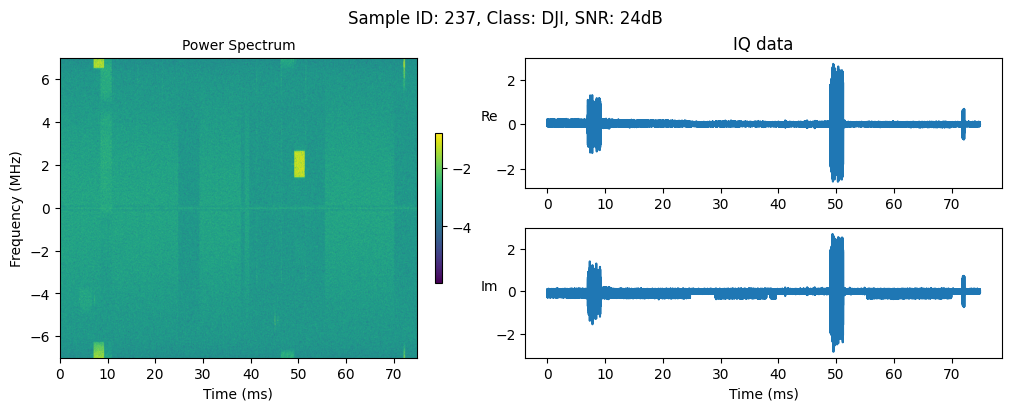

In [4]:
project_path = '/home/ghoth/thesis_drone_detection/'
# data_path = './data/'
data_path = '/home/ghoth/thesis_drone_detection/Robust-Drone-Detection-and-Classification/data/drone_RF_data/'

# read statistics/class count of the dataset
dataset_stats = pd.read_csv(data_path + 'class_stats.csv', index_col=0)
class_names = dataset_stats['class'].values

# read SNR count of the dataset
snr_stats = pd.read_csv(data_path + 'SNR_stats.csv', index_col=0)
snr_list = snr_stats['SNR'].values

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# setup transform: IQ -> SPEC
data_transform = transform_spectrogram(device=device) # create transform object
# data_transform.to(device=device, dtype=torch.float32) # put transform on GPU (if available)
# create dataset object
drone_dataset = drone_data_dataset(path=data_path, device=device, transform=data_transform)

# split data with stratified kfold
dataset_indices = list(range(len(drone_dataset)))

# get targets, snrs and files of the dataset
targets = drone_dataset.get_targets()
snr_list = drone_dataset.get_snrs()
files = drone_dataset.get_files()

# get sample from the dataset
iq_data, target, snr, sample_id, transformed_data = drone_dataset[9276]

print(transformed_data.shape)

# plot IQ data
target_name = class_names[target]
plot_title = 'Sample ID: ' + str(sample_id) + ', Class: ' + target_name + ', SNR: ' + str(snr.numpy()) + 'dB'
print(plot_title)
# plot_two_channel_iq(iq_data.cpu().numpy(), title=plot_title)
# plot_two_channel_spectrogram(transformed_data.cpu().numpy(), title=plot_title)
# plot_input_data(spectrogram_2d=transformed_data.cpu().numpy(),
#                 iq_2d=iq_data.cpu().numpy(), title=plot_title)
# plot_log_prower_spec(spectrogram_2d=transformed_data.cpu().numpy(), n_fft=1024, sampling_rate=14e6, title=plot_title)
plot_input_data_powerspec(spectrogram_2d=transformed_data.cpu().numpy(), iq_2d=iq_data.cpu().numpy(), title=plot_title)